# Building a Dialogue Summarization Model Using LSTM and Attention Mechanism

I am working on a project to summarize dialogues into short summaries. For this, I am using Long Short-Term Memory (LSTM) architecture to build the model. In this approach, I am creating an encoder-decoder model with an attention feature to manage tasks where one sequence is transformed into another, which is commonly used in language tasks like summarizing text or translating.

The encoder reads the input sequence and captures important information throughout the input steps, turning it into a set of hidden states. These hidden states are then sent to the decoder, which generates the output sequence one step at a time, using its own internal states and the information provided by the encoder.

To help the model focus on the important parts of the input during each decoding step, I added an attention mechanism. This allows the decoder to pay attention to specific parts of the encoded sequence as needed, rather than relying on a fixed-size context, which improves accuracy, especially for longer sequences.

The model is set up with categorical loss and accuracy as performance measures, allowing it to predict multiple classes for each word in the sequence. During training, I am using early stopping with a patience level of 3 to avoid overfitting. This means that if there is no improvement in the validation loss, training will stop. The model is performing fairly well, but I still notice that some of the outputs are not of the best quality.

Since training the dataset takes a lot of time, we may need to use a GPU. For the training data, I am using the Hugging Face library called knkarthick/samsum.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install contractions
#!pip install pydot
!pip install datasets
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.

In [28]:
#import all the required libraries
#this also include two classes as helper funciton which need ot be uused to do some cleanup and tokenization
from datasets import load_dataset
import pandas as pd
from textblob import Word
import nltk
import pickle
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Embedding, Attention, Concatenate, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
from tensorflow.keras.models import load_model
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/text_summarization_LSTM/')
from TextProcessing import TextProcessing
from PreprocessorUtils import PreprocessorUtils
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Check if a GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available:", gpu_available)
else:
    print("No GPU found.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
dataset = load_dataset("knkarthick/samsum")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/9.26M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/504k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/522k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

In [6]:
train_df.sample(5)

,id,dialogue,summary
5257,13680696,James: hows the weather by the way its blumin ...,James's dogs are well. Mia is allowed to see t...
13130,13829687,"Cathreen: Dear Ruth, it was so wonderful to me...",Cathreen enjoyed her meet with Ruth and the pr...
13640,13682009,Ema: <file_photo><file_photo><file_photo><file...,Ema send Wendy photos and they make fun of the...
14578,13828267,Sam: not sure if I will be at school tomorrow\...,Sam does not feel well and he probably will no...
8587,13819929,Jack: <file_photo>\nMarianne: He's so cute\nKa...,Jack shares a cute picture.


In [7]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)
# Remove the 'id' column from both train_df and test_df
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14732, 3)
test_df shape:  (819, 3)
train_df shape:  (14732, 2)
test_df shape:  (819, 2)


In [8]:
#do some cleanup by removing null, but not much to clean up though
train_df.describe(include='all')
#drop null rows
train_df.dropna(inplace = True)
train_df.describe(include='all')


,dialogue,summary
count,14731,14731
unique,14255,14729
top,"Jimmy: Hey, guess what? My car's completely ka...",Seth's pet Oreo that he got when he was 10 is ...
freq,4,2


In [9]:
#use the TextProcessing class to process the text, this will cleanup all special character as it will allow model to concentrate on main text while learning
processor = TextProcessing()
train_df = processor.process_text(train_df)
test_df = processor.process_text(test_df)
train_df.sample(5)

,dialogue,summary
465,katya hello katya happy birthday katya hug mar...,katya wishes marcin happy birthday and marcin ...
6001,adele what was the name of the show you told m...,martin recommends a new movie called money hei...
478,taylor wash my car please dad okay taylor thanks,dad will wash taylors car
566,jason how was your flight patrick i met the lo...,patrick met a woman on a flight and chatted wi...
2473,nora filegif zoey hahahha cute mila filegif lo...,nora zoey and mila are having a gif war


In [10]:
#reduce the dataset for testing purpse
# Reduce the train_df to 2000 records
#train_df = train_df.iloc[:1000]

# Reduce the test_df to 600 records
#test_df = test_df.iloc[:100]


In [11]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14731, 2)
test_df shape:  (819, 2)


In the summarization and generative tasks, using special tokens like \<start> and \<end> in summaries is essential. These tokens clearly indicate where the summary begins and ends, helping the model understand the text's structure. This clarity improves the model's ability to generate consistent outputs by defining clear boundaries for generating summaries. Ultimately, this approach enhances the model's performance, ensuring it produces concise and relevant summaries that effectively communicate the intended message.

In [12]:
#add eot to start and end of the summary
train_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['summary']]
test_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['summary']]

train_df['summary']

,summary
0,<start> amanda baked cookies and will bring je...
1,<start> olivia and olivier are voting for libe...
2,<start> kim may try the pomodoro technique rec...
3,<start> edward thinks he is in love with bella...
4,<start> sam is confused because he overheard r...
...,...
14727,<start> romeo is trying to get greta to add hi...
14728,<start> theresa is at work she gets free food ...
14729,<start> japan is going to hunt whales again is...
14730,<start> celia could not make it to the afterno...


The PreprocessorUtils class is essential for preparing text data before training machine learning models, particularly in natural language processing tasks. It handles various preprocessing steps, such as tokenization, which converts raw text into numerical sequences that models can understand. This class also allows for saving and loading tokenizers, ensuring consistent text representation across different datasets. By converting dialogues and summaries into sequences, it facilitates the training process, enabling models to learn effectively.

In [13]:
#applicable only for train data.
utils = PreprocessorUtils()
tok = utils.fit_tokenizer(train_df['dialogue'], train_df['summary'], '/content/drive/My Drive/Summarization/tokenizer/tokenizer.pickle')
print('word index length :', len(tok.word_index))
print('token doc count :', tok.document_count)


Tokenizer saved successfully!
word index length : 33278
token doc count : 14731


This call utilizes a tokenizer to transform text data into numerical sequences. Specifically, it takes a DataFrame containing dialogues and their corresponding summaries, applying the tokenizer to each text entry. This conversion is crucial because machine learning models require numerical input rather than raw text. By creating these sequences, we prepare the data for training and test, enabling the model to learn patterns and relationships between dialogues and summaries more effectively. The modified DataFrame is then returned for further processing.

In [14]:
#convert text to sequence (we will convert this for both train and test)
train_df = utils.convert_to_sequences(train_df)
test_df = utils.convert_to_sequences(test_df)

In [15]:
#calculate max sequence length (applicable only for training)
#max_length_combined = utils.calculate_max_sequence_length(train_df['dialogue'], train_df['summary'], test_df['dialogue'], test_df['summary'])
#print('max_length_combined :', max_length_combined)
#utils.max_length_combined = 824
#utils.max_length_combined

We need to pad sequences to ensure all input data has the same length. This is important because machine learning models require fixed-size inputs. By padding the dialogues and summaries, we make it easier for the model to process the data correctly and learn from it effectively.

In [16]:
#pad the sequence
x_train, y_train = utils.pad_sequences(train_df['dialogue'], train_df['summary'])
x_test, y_test = utils.pad_sequences(test_df['dialogue'], test_df['summary'])

# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 824)
Shape of x_test: (819, 824)
Shape of y_train: (14731, 824)
Shape of y_test: (819, 824)


In [17]:
#print the sequence of tokens
for num in train_df['dialogue'][0]:
    print(num, end=' ')

419 1 3358 1527 16 2 68 52 580 67 419 1 10 208 2 95 

In [18]:
#the word index will be used later to convert the newly generated tokens into words from the dictionary
print(utils.tokenizer.index_word)
utils.print_sequence_words(train_df['dialogue'][0])
utils.print_sequence_words(train_df['summary'][0])

{1: 'i', 2: 'you', 3: 'to', 4: 'the', 5: 'is', 6: 'it', 7: 'a', 8: 'and', 9: 'not', 10: 'will', 11: 'in', 12: 'for', 13: 'are', 14: 'have', 15: 'that', 16: 'do', 17: 'start', 18: 'end', 19: 'of', 20: 'my', 21: 'am', 22: 'but', 23: 'so', 24: 'we', 25: 'be', 26: 'on', 27: 'what', 28: 'at', 29: 'me', 30: 'with', 31: 'he', 32: 'know', 33: 'she', 34: 'was', 35: 'they', 36: 'just', 37: 'about', 38: 'this', 39: 'can', 40: 'there', 41: 'no', 42: 'her', 43: 'ok', 44: 'like', 45: 'going', 46: 'did', 47: 'out', 48: 'your', 49: 'how', 50: 'would', 51: 'go', 52: 'some', 53: 'good', 54: 'see', 55: 'eyes', 56: 'as', 57: 'if', 58: 'tears', 59: 'up', 60: 'think', 61: 'one', 62: 'get', 63: 'yeah', 64: 'all', 65: 'has', 66: 'yes', 67: 'sure', 68: 'want', 69: 'from', 70: 'too', 71: 'really', 72: 'now', 73: 'well', 74: 'him', 75: 'his', 76: 'thanks', 77: 'when', 78: 'come', 79: 'need', 80: 'cannot', 81: 'or', 82: 'got', 83: 'then', 84: 'them', 85: 'oh', 86: 'should', 87: 'an', 88: 'd', 89: 'new', 90: 'why'

In [19]:
#modeling, encoder/decoder with attention
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=260)(encoder_inputs)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=260)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 824)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 824)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 824, 260)       │      8,652,540 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 824, 260)       │      8,652,540 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 824, 64),      │         83,200 │ embedding[0][0]        │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 824, 64),      │         83,200 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_1[0][1],          │
│                           │ 64)]                   │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 824, 64)        │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 824, 128)       │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 824, 33279)     │      4,292,991 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,764,471 (83.02 MB)

 Trainable params: 21,764,471 (83.02 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with Early stopping configured
history = model.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 345s 368ms/step - accuracy: 0.9682 - loss: 1.2909 - val_accuracy: 0.9870 - val_loss: 0.1083
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 382s 372ms/step - accuracy: 0.9880 - loss: 0.1012 - val_accuracy: 0.9915 - val_loss: 0.0707
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 384s 374ms/step - accuracy: 0.9917 - loss: 0.0704 - val_accuracy: 0.9941 - val_loss: 0.0522
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 392s 385ms/step - accuracy: 0.9941 - loss: 0.0525 - val_accuracy: 0.9956 - val_loss: 0.0404
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 343s 373ms/step - accuracy: 0.9955 - loss: 0.0408 - val_accuracy: 0.9965 - val_loss: 0.0322


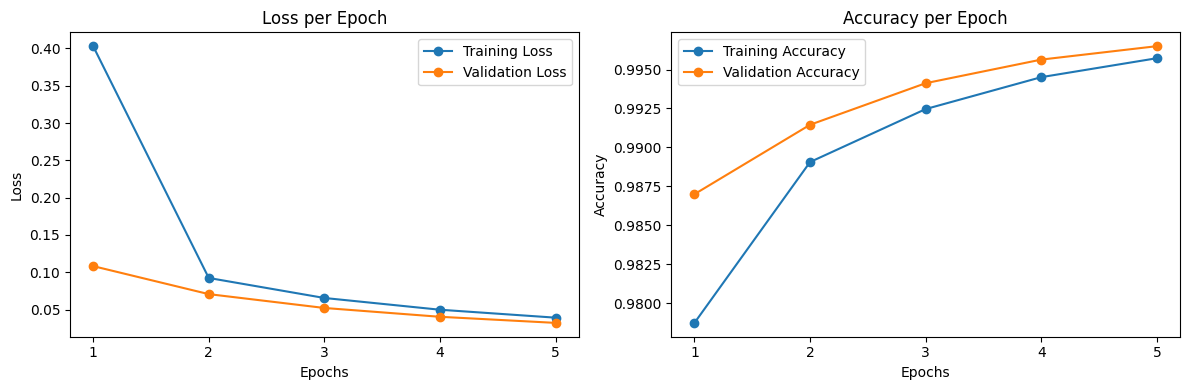

In [21]:
#plot the graph for accuracy and loss for both training and validation
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

The BLEU (Bilingual Evaluation Understudy) score is an evaluation metric we are using in natural language processing (NLP) for tasks such as text summarization, translation, etc. It measures the similarity between a generated text and a reference text by assessing the overlap of words or phrases (n-grams) between them. A higher BLEU score indicates a closer match between the predicted text and the actual reference, suggesting that the model captures more of the intended content and phrasing.

In this code implementation, it is used to evaluate the model's ability to generate accurate summaries by comparing each predicted summary against the actual summaries in the test set.

In [22]:
# lets calculate teh Bleu score to see how the predicted and the actual is ranked when compared
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}

# Convert tokens to sentences function
def tokens_to_sentence(tokens, rev_tokenizer, skip_special_tokens=['<start>', '<end>', 0]):
    return ' '.join([rev_tokenizer.get(token, '<unknown>') for token in tokens if token not in skip_special_tokens])

# Define the batch size
batch_size = 16


# Prepare the predictions and references
predicted_summaries = []
references = []

# Prediction loop
for start in range(0, len(x_test), batch_size):
    end = min(start + batch_size, len(x_test))
    x_batch = x_test[start:end]
    y_batch = y_test[start:end]

    # Model predictions
    predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

    # Convert predictions to sentences
    predicted_tokens_np = np.argmax(predictions, axis=-1)
    for predicted_tokens in predicted_tokens_np:
        predicted_sentence = tokens_to_sentence(predicted_tokens, rev_tok_summary)
        predicted_summaries.append(predicted_sentence)

    # Convert true summaries to sentences for BLEU
    for true_tokens in y_batch:
        true_sentence = tokens_to_sentence(true_tokens, rev_tok_summary)
        references.append([true_sentence])  # Changed to a list of lists (each inner list contains a single sentence)

# SacreBLEU expects references as a list of lists (with one list per predicted sentence)
bleu_score = sacrebleu.corpus_bleu(predicted_summaries, references)
print(f"BLEU Score: {bleu_score.score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [26]:
# Save the entire model
model.save('/content/drive/My Drive/Summarization/model/encoder_decoder_model.h5')
print('Model saved succesfully!!')

Model saved succesfully!!


The prediction code loads a pre-trained model and tokenizer, processes sample data, and converts it to sequences. It generates summaries using the model, mapping tokens to words while excluding padding and special tokens. The result then outputs the predicted summaries alongside original dialogues for comparison.

In [33]:
#predicton with Attention
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# Load the saved Tokenizer (from a pickle file)
with open('/content/drive/My Drive/Summarization/tokenizer/tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

# Reverse token dictionaries
rev_tok = {idx: word for word, idx in tok.word_index.items()}

# Load the model from file
model = load_model('/content/drive/My Drive/Summarization/model/encoder_decoder_model.h5')

val_df = pd.DataFrame(dataset['validation']).sample(1)

#process text
processor = TextProcessing()
val_df = processor.process_text(val_df)

# Add "start" and "end" tokens to the 'dialog' and 'summary' columns
val_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in val_df['summary']]


#convert to sequence for new data
utils = PreprocessorUtils()
utils.tokenizer = tok
val_df = utils.convert_to_sequences(val_df)
#print(val_df['dialogue'][0])
#utils.print_sequence_words(val_df['dialogue'][0])

x_val, y_val = utils.pad_sequences(val_df['dialogue'], val_df['summary'])

num_samples = 5
x_val_subset = x_val[:num_samples]
y_val_padded_subset = y_val[:num_samples]

new_pred = model.predict([x_val_subset, y_val_padded_subset], batch_size=16)
#print('Shape of new_pred:', new_pred.shape)

#new pred token
new_pred_token = np.argmax(new_pred, axis=-1)
print('Shape of new_pred_token:', new_pred_token.shape)

#Map token to remove start and end
new_sentences = []
for sample in new_pred_token:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    new_sentences.append(sentence)

# Map the dialogue input to sentences
english_sentences = []
for sample in x_val_subset:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0])  # Exclude padding token
    english_sentences.append(sentence)

# Print the dialogue, predicted summary, and actual summary
for idx, (eng_sentence, new_sentence) in enumerate(zip(english_sentences, new_sentences)):
    print(f'Dialogue {idx + 1}: {eng_sentence}')
    print(f'Predicted summary {idx + 1}: {new_sentence}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Shape of new_pred_token: (1, 824)
Dialogue 1: linda these chocolates are amazing julian i hope you would like it linda thank you very much linda where did you buy it julian that is my secret julian i cannot tell you linda oh please julian no julian but i can buy it to you more often linda would you be so nice julian of course everything for you linda you are so sweet as these chocolates are linda 3
Predicted summary 1: linda loves the beth bought for her
